In [60]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from spacy.lang.pt.stop_words import STOP_WORDS
from spacy.training import Example
from sklearn.metrics import confusion_matrix, accuracy_score

### Database

In [71]:
base = pd.read_csv('data/feellings/base_treinamento.txt', encoding='utf-8')

In [5]:
base.shape

(196, 2)

In [6]:
base.head()

,texto,emocao
0,este trabalho é agradável,alegria
1,gosto de ficar no seu aconchego,alegria
2,fiz a adesão ao curso hoje,alegria
3,eu sou admirada por muitos,alegria
4,adoro como você,alegria


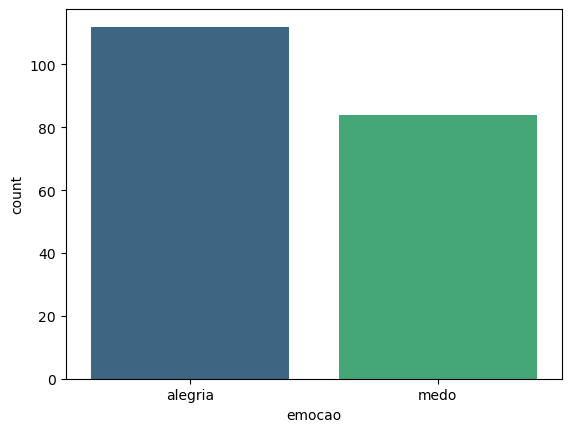

In [12]:
sns.countplot(x='emocao', hue='emocao', data=base, palette='viridis', legend=False);

### Text preprocessing function

In [13]:
pontuations = string.punctuation
pontuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
stop_words = STOP_WORDS

In [17]:
nlp = spacy.load('pt_core_news_sm')
nlp

In [25]:
def preprocessing(text):
    text = text.lower()
    doc = nlp(text)
    
    list = []
    
    for token in doc:
        #list.append(token.text)
        list.append(token.lemma_)
        
    list = [word for word in list if word not in stop_words and word not in pontuations]
    list = ' '.join([str(element) for element in list if not element.isdigit()]) 
                
    return list

In [26]:
test = preprocessing('Eu estou me esforçando para aprender NLP')
test

'esforçar aprender nlp'

### Preprocessing on database

##### Text cleaning

In [27]:
base['texto'] = base['texto'].apply(preprocessing)

##### Class treatment

In [28]:
exemple_base = [["algumas coisas são importantes demais para desistir", {"ALEGRIA": True, "MEDO": False}],
                ["este lugar é assustador", {"ALEGRIA": False, "MEDO": True}]]

In [29]:
base_final = []

i = 0

for text, emotion in zip(base['texto'], base['emocao']):
    if emotion == 'alegria':
        dic = {"ALEGRIA": True, "MEDO": False}
    else:
        dic = {"ALEGRIA": False, "MEDO": True}
        
    base_final.append([text, dic.copy()])

In [30]:
len(base_final)

196

### Building the classifier

In [32]:
model = spacy.blank('pt')
categories = model.add_pipe('textcat')
categories.add_label("ALEGRIA")
categories.add_label("MEDO")
history = []

In [35]:
model.begin_training()
for epoch in range(1000):
    random.shuffle(base_final)
    losses = {}
    for batch in spacy.util.minibatch(base_final, size=30):
        examples = [Example.from_dict(model.make_doc(text), {'cats': entities}) for text, entities in batch]
        model.update(examples, losses=losses)
    if epoch % 100 == 0:
        print(losses)
        history.append(losses)

{'textcat': 1.7530183494091034}
{'textcat': 4.5789292930226155e-11}
{'textcat': 4.931719691913389e-12}
{'textcat': 1.2820460906543159e-12}
{'textcat': 4.535567291885515e-13}
{'textcat': 1.8496754692134965e-13}
{'textcat': 8.903803369036544e-14}
{'textcat': 4.309309045331402e-14}
{'textcat': 2.374687371401444e-14}
{'textcat': 1.1846174042808656e-14}


In [36]:
history_loss = []
for i in history:
    history_loss.append(i.get('textcat'))

In [37]:
history_loss = np.array(history_loss)
history_loss

array([1.75301835e+00, 4.57892929e-11, 4.93171969e-12, 1.28204609e-12,
       4.53556729e-13, 1.84967547e-13, 8.90380337e-14, 4.30930905e-14,
       2.37468737e-14, 1.18461740e-14])

Text(0, 0.5, 'Erro')

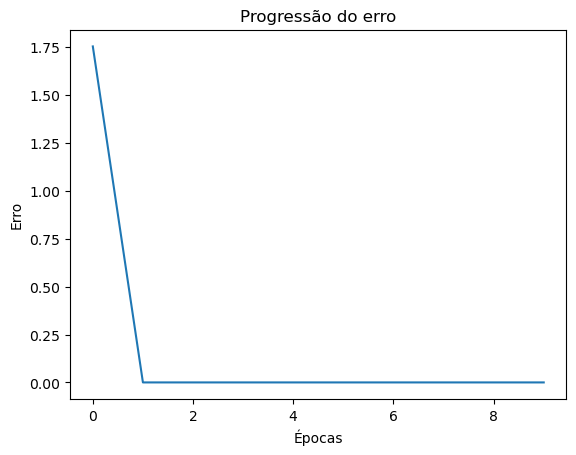

In [39]:
plt.plot(history_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [41]:
model.to_disk('model')

### One phrase test

In [42]:
loaded_model = spacy.load('data/feellings/model')
loaded_model

In [50]:
positive_text = 'Eu estou muito feliz'

In [51]:
positive_text = preprocessing(positive_text)
positive_text

'feliz'

In [52]:
prediction = loaded_model(positive_text)
prediction

feliz

In [53]:
prediction.cats

{'ALEGRIA': 0.32886654138565063, 'MEDO': 0.6711334586143494}

In [54]:
negative_text = 'Eu estou com medo'
prediction = loaded_model(negative_text)
prediction.cats

{'ALEGRIA': 0.3349294066429138, 'MEDO': 0.6650705933570862}

### Model evaluation

##### Train base evaluation

In [55]:
predictions = []
for text in base['texto']:
    prediction = loaded_model(text)
    predictions.append(prediction.cats)

In [56]:
predictions

[{'ALEGRIA': 1.0, 'MEDO': 1.2586609532405646e-09},
 {'ALEGRIA': 1.0, 'MEDO': 2.8357883152807517e-08},
 {'ALEGRIA': 1.0, 'MEDO': 6.725753731728901e-09},
 {'ALEGRIA': 1.0, 'MEDO': 2.0394624655750704e-08},
 {'ALEGRIA': 1.0, 'MEDO': 2.101369300788747e-09},
 {'ALEGRIA': 1.0, 'MEDO': 7.181574446235572e-09},
 {'ALEGRIA': 1.0, 'MEDO': 8.462415657106703e-09},
 {'ALEGRIA': 1.0, 'MEDO': 1.3106994600775579e-08},
 {'ALEGRIA': 1.0, 'MEDO': 4.357158189804977e-09},
 {'ALEGRIA': 1.0, 'MEDO': 2.6822704057849478e-08},
 {'ALEGRIA': 1.0, 'MEDO': 2.1379080727967903e-09},
 {'ALEGRIA': 1.0, 'MEDO': 1.7385346495757403e-09},
 {'ALEGRIA': 1.0, 'MEDO': 2.0086470264857326e-09},
 {'ALEGRIA': 1.0, 'MEDO': 1.0111391723910401e-08},
 {'ALEGRIA': 1.0, 'MEDO': 3.542954374324836e-08},
 {'ALEGRIA': 1.0, 'MEDO': 1.8691650893742917e-08},
 {'ALEGRIA': 1.0, 'MEDO': 5.769434707758592e-09},
 {'ALEGRIA': 1.0, 'MEDO': 1.0744111156313352e-09},
 {'ALEGRIA': 1.0, 'MEDO': 7.58311458071148e-09},
 {'ALEGRIA': 1.0, 'MEDO': 7.705322602191

In [57]:
final_predictions = []
for prediction in predictions:
    if prediction['ALEGRIA'] > prediction['MEDO']:
        final_predictions.append('alegria')
    else:
        final_predictions.append('medo')
final_predictions = np.array(final_predictions)

In [58]:
final_predictions

array(['alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 

In [59]:
ans = base['emocao'].values
ans

array(['alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 'alegria', 'alegria',
       'alegria', 'alegria', 'alegria', 'alegria', 

In [61]:
accuracy_score(ans, final_predictions)

1.0

In [62]:
cm = confusion_matrix(ans, final_predictions)
cm

array([[112,   0],
       [  0,  84]], dtype=int64)

##### Test base evaluation

In [63]:
test_base = pd.read_csv('data/feellings/base_teste.txt', encoding='utf-8')

In [64]:
test_base['texto'] = test_base['texto'].apply(preprocessing)

In [65]:
predictions = []
for text in test_base['texto']:
    prediction = loaded_model(text)
    predictions.append(prediction.cats)

In [66]:
final_predictions = []
for prediction in predictions:
    if prediction['ALEGRIA'] > prediction['MEDO']:
        final_predictions.append('alegria')
    else:
        final_predictions.append('medo')
        
final_predictions = np.array(final_predictions)

In [67]:
ans = test_base['emocao'].values

In [68]:
accuracy_score(ans, final_predictions)

0.5595238095238095

In [69]:
cm = confusion_matrix(ans, final_predictions)
cm

array([[34, 14],
       [23, 13]], dtype=int64)